# Initialization

In [ ]:
%reload_ext autoreload
%autoreload 2

In [1]:
from result_saver import SaverProvider

provider = SaverProvider()

# Generate Extreme Data

In [2]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 7
ROUNDS = 7
OTHER_DATE = '2021-11-11'
_RESETS = True
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


In [3]:
# Get noise model
p1Q = 0
pZ = 0
pRE = 0
pXY = 0

p2Q = 1e-2
# pRO = 15e-2
pRO = 0

multiplicator = 0
p1Q = 5e-3 * multiplicator
p2Q = 5e-3 * multiplicator
pXY = 5e-3 * multiplicator
pZ = 5e-3 * multiplicator
pRO = 8e-3 * multiplicator # slightly lower than device median because no soft flips
pRE = 5e-3 * multiplicator

p1Q = multiplicator
p2Q = multiplicator
pXY = multiplicator
pZ = multiplicator
pRO = 5e-2#multiplicator
pRE = multiplicator

noise_model = simulator.get_noise_model(p1Q, p2Q, pXY, pZ, pRO, pRE)

In [4]:
SHOTS = int(1e4)
P_AMBIG = 0

extreme_IQ_data = simulator.generate_extreme_IQ(SHOTS, P_AMBIG, noise_model=noise_model)
print(extreme_IQ_data.shape)

18:27:21 Warning: Getting counts via stim. This may take time.... IN FILE: /Users/mha/My_Drive/Desktop/Studium/Physik/MSc/Semester_3/IBM/IBM_GIT/Soft-Info/src/soft_info/IQ_data/simulator.py, LINE: 51


# Get counts from IQ data

In [7]:
import cpp_soft_info

print(cpp_soft_info.get_counts(extreme_IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))

NameError: name 'extreme_IQ_data' is not defined

# Decode IQ data

In [33]:
import pymatching
import stim


reset_err = pRE if _RESETS else 0

circuit = stim.Circuit.generated("repetition_code:memory",
                                distance=DISTANCE,
                                rounds=ROUNDS,
                                after_clifford_depolarization=0, #two-qubit-fidelity,
                                after_reset_flip_probability=0, #reset error,
                                before_measure_flip_probability=5e-2, #measurement error,
                                before_round_data_depolarization=0) #idle error)
print(circuit)

model = circuit.detector_error_model(decompose_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)

P_DATA = 1e-2
P_MIXED = 1e-2
P_MEAS = P_AMBIG

# print(circuit)

R 0 1 2 3 4 5 6 7 8 9 10 11 12
TICK
CX 0 1 2 3 4 5 6 7 8 9 10 11
TICK
CX 2 1 4 3 6 5 8 7 10 9 12 11
TICK
X_ERROR(0.05) 1 3 5 7 9 11
MR 1 3 5 7 9 11
DETECTOR(1, 0) rec[-6]
DETECTOR(3, 0) rec[-5]
DETECTOR(5, 0) rec[-4]
DETECTOR(7, 0) rec[-3]
DETECTOR(9, 0) rec[-2]
DETECTOR(11, 0) rec[-1]
REPEAT 6 {
    TICK
    CX 0 1 2 3 4 5 6 7 8 9 10 11
    TICK
    CX 2 1 4 3 6 5 8 7 10 9 12 11
    TICK
    X_ERROR(0.05) 1 3 5 7 9 11
    MR 1 3 5 7 9 11
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-6] rec[-12]
    DETECTOR(3, 0) rec[-5] rec[-11]
    DETECTOR(5, 0) rec[-4] rec[-10]
    DETECTOR(7, 0) rec[-3] rec[-9]
    DETECTOR(9, 0) rec[-2] rec[-8]
    DETECTOR(11, 0) rec[-1] rec[-7]
}
X_ERROR(0.05) 0 2 4 6 8 10 12
M 0 2 4 6 8 10 12
DETECTOR(1, 1) rec[-6] rec[-7] rec[-13]
DETECTOR(3, 1) rec[-5] rec[-6] rec[-12]
DETECTOR(5, 1) rec[-4] rec[-5] rec[-11]
DETECTOR(7, 1) rec[-3] rec[-4] rec[-10]
DETECTOR(9, 1) rec[-2] rec[-3] rec[-9]
DETECTOR(11, 1) rec[-1] rec[-2] rec[-8]
OBSERVABLE_INCLUDE(0) rec[-1]


from qiskit_qec.utils import get_stim_circuits

stim_circ = get_stim_circuits(simulator.code.circuit['0'])
# print(stim_circ)
stim_circ = stim_circ[0][0]
print(stim_circ)

counts_simulator = simulator.get_counts(shots=2, noise_model=noise_model, logical="0")
print(counts_simulator)
counts_stim = stim_circ.compile_sampler(seed=42).sample(2)
print(counts_stim)

assert counts_simulator.all() == counts_stim.all()
print()
print("assert passed!")

In [30]:
import cpp_soft_info

matching = pymatching.Matching.from_detector_error_model(model)
# cpp_soft_info.reweight_edges_based_on_error_probs(matching._matching_graph, counts, False, "spitz")

result = cpp_soft_info.decode_IQ_shots(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True, p_offset = 1)
print("num_errors:", result.num_errors, "out of", len(extreme_IQ_data), "shots")

NameError: name 'extreme_IQ_data' is not defined

In [59]:
matching = pymatching.Matching.from_detector_error_model(model)
result_flat = cpp_soft_info.decode_IQ_shots_flat(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=True)
print("num_errors:", result_flat.num_errors, "out of", len(extreme_IQ_data), "shots")


num_errors: 27 out of 10000 shots


In [68]:
matching = pymatching.Matching.from_detector_error_model(model)

p_meas = P_MEAS + pRO
p_meas = -1
p_meas = 45e-2

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(matching._matching_graph, extreme_IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=True)

print("num_errors:", result_informed.num_errors, "out of", len(extreme_IQ_data), "shots")
         
# takes 1s

num_errors: 0 out of 10000 shots


# Plot the results

In [46]:
print("\nIQ:", result.indices, "\nFlat:", result_flat.indices, "\nInformed", result_informed.indices)


IQ: [64, 1114, 2155, 2194, 2341, 2685, 2919, 3327, 3684, 3711, 3762, 3767, 4103, 4228, 4257, 4270, 4370, 4467, 4773, 4860, 5063, 5092, 5123, 5138, 5655, 5714, 5737, 6186, 6299, 6398, 7137, 7256, 7391, 7678, 7787, 8055, 8091, 8142, 8303, 8491, 8715, 8798, 9157, 9209, 9599, 9702, 9743, 9801, 9859] 
Flat: [7, 9, 11, 12, 13, 16, 20, 23, 32, 33, 34, 42, 44, 57, 64, 66, 67, 74, 76, 78, 84, 85, 87, 90, 91, 92, 95, 96, 103, 110, 112, 116, 118, 127, 129, 135, 138, 139, 142, 148, 151, 155, 157, 159, 161, 162, 165, 167, 170, 172, 175, 177, 178, 184, 186, 188, 189, 195, 199, 201, 203, 205, 206, 210, 213, 220, 222, 224, 228, 232, 237, 238, 241, 242, 243, 244, 245, 247, 249, 250, 252, 256, 261, 267, 277, 280, 281, 284, 288, 289, 292, 295, 305, 307, 308, 312, 313, 317, 322, 327, 328, 330, 332, 333, 334, 336, 338, 339, 342, 350, 353, 357, 363, 367, 369, 375, 381, 384, 388, 392, 394, 398, 400, 409, 411, 412, 414, 419, 420, 424, 425, 426, 427, 429, 431, 434, 435, 437, 438, 442, 449, 451, 458, 460, 461,

-----IQ-----


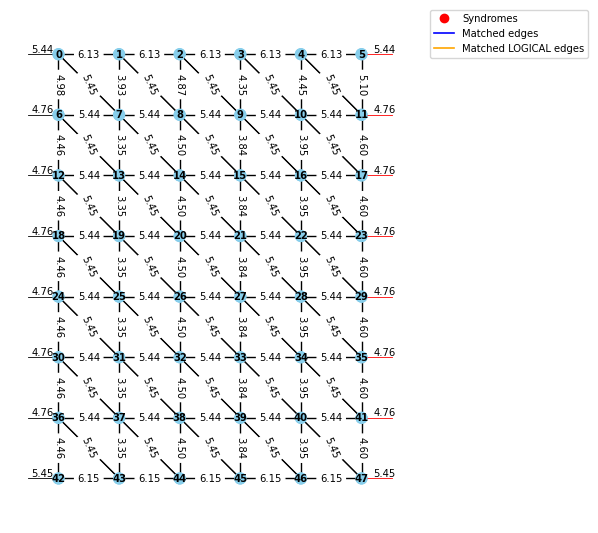

-----flat-----


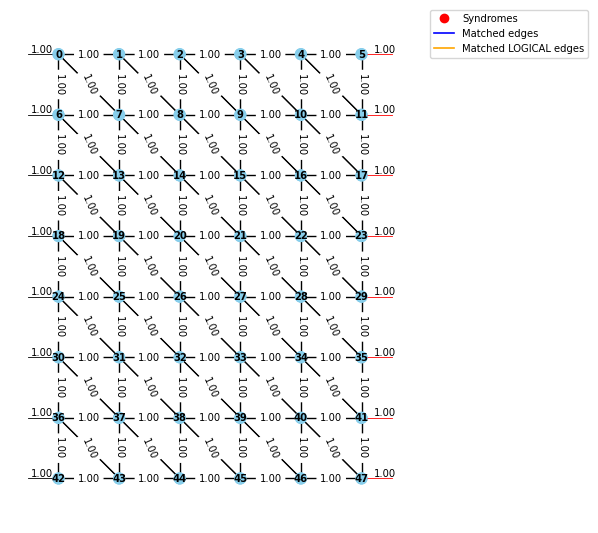

-----INFORMED-----


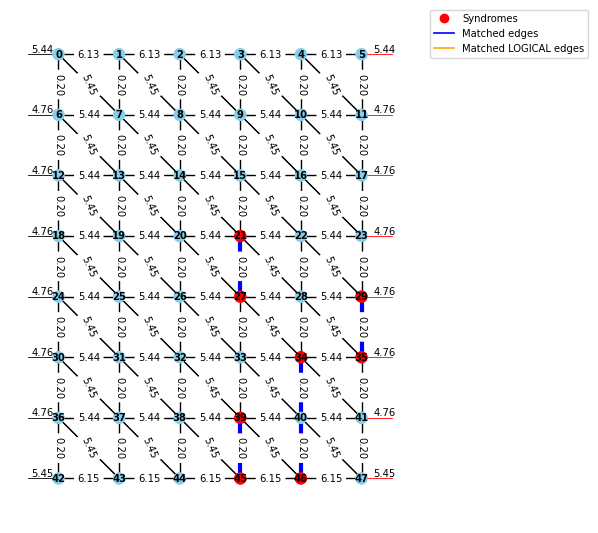

In [69]:
from soft_info import draw_matching_graph


index = 64

fig_size = (4, 13)
scale_factor = 0.6

to_be_result = result
details = to_be_result.error_details[index]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print("-----flat-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_informed
details = to_be_result.error_details[index]
print("-----INFORMED-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [13]:
print("indices that are in informed but not in IQ:")
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print(informed_not_in_iq)
print("indices that are in IQ but not in informed:")
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print(iq_not_in_informed)

print()

print("indices that are in IQ but not in flat:")
iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print(iq_not_in_flat)
print("indices that are in flat but not in IQ:")
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print(flat_not_in_iq)



indices that are in informed but not in IQ:
[0, 1, 2, 3, 5, 6, 8, 11, 14, 18, 25, 27, 28, 31, 35, 36, 40, 44, 45, 46, 47, 51, 52, 53, 55, 56, 58, 61, 64, 70, 74, 76, 78, 79, 88, 94, 97, 100, 110, 114, 117, 121, 127, 132, 133, 135, 136, 144, 146, 149, 152, 156, 162, 163, 165, 166, 169, 171, 172, 174, 175, 176, 182, 187, 190, 193, 194, 205, 208, 211, 212, 213, 215, 216, 217, 218, 220, 222, 227, 230, 232, 235, 240, 245, 249, 254, 261, 268, 269, 271, 273, 274, 277, 278, 280, 281, 282, 284, 287, 288, 289, 294, 296, 297, 302, 304, 306, 307, 308, 313, 316, 325, 326, 330, 335, 336, 337, 339, 340, 341, 342, 347, 349, 359, 360, 362, 363, 373, 375, 379, 381, 383, 385, 388, 391, 392, 393, 398, 400, 404, 406, 409, 410, 413, 414, 417, 419, 420, 421, 422, 424, 428, 433, 434, 436, 438, 442, 444, 445, 446, 448, 449, 451, 456, 457, 463, 464, 473, 478, 480, 483, 484, 485, 487, 493, 494, 495, 505, 506, 508, 509, 516, 518, 527, 530, 532, 535, 536, 537, 539, 542, 546, 547, 550, 556, 561, 564, 566, 568, 569,

# Analyse specific shots

{'0000000 100101 000000 101010 000001 101000 010110 001101': 1}
-----IQ-----


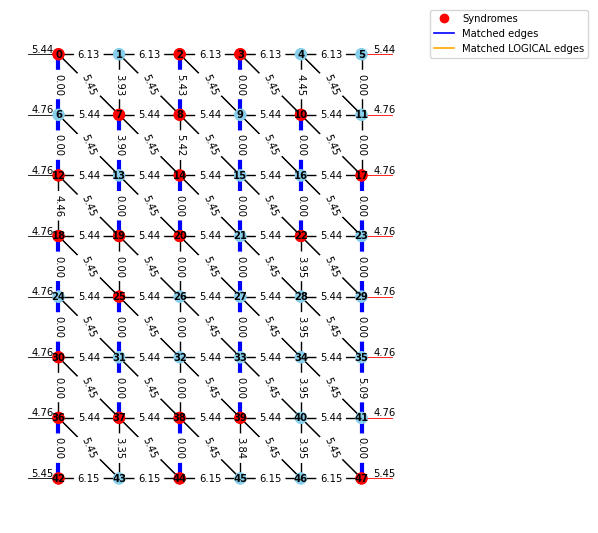

In [50]:
index = 64
IQ_data = extreme_IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                           common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=True)


print(cpp_soft_info.get_counts(IQ_data, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]
print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)